# Forecasting with FB Prophet

https://facebook.github.io/prophet/

From the facebook page...

"Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well."



This python program will forecast out the stock price of the chosen company AMD. 
This will be the first program of two to attempt to accurately forecast stick prices. 

Stock data is time series although there is no real seasionality persay although AMD may have some seasonality in there data due to an increase in their processors during the November and December time frames. Will this mean an increase in stock price? We will see. 

In [2]:
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import io, base64, os, json, re, glob
import datetime
from datetime import timedelta
import pandas as pd
import pydata_google_auth
import pandas_datareader as web
import numpy as np

from fbprophet import Prophet

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**There will be two ways we want to forecast. 
The first will be to take the daily data. 
The second method will be to resample the dataset to a Monthly and Yearly data set to compare with the daily.**

# Import / Scrape Data

In [3]:
# Lets grab the data from Yahoo and store the vairable as amd which is the name of the stock
# Grab the data for AMD
amd = web.DataReader('AMD', data_source='yahoo', start = "2013-01-01", end = '2020-07-10')

# From here we can split the methods by storing different variables
# amd will ocntinue to be our original method to forecast by day
# The second method will be stored in two variables

amd_m2_year = amd
amd_m2_month = amd

# This is necessary as we want to resample the data which summarizes the data into months as well as years
# To do this in the next section we need to take the index and pop it off to make it a column as 
# the current index is the date format and we cannot run Prophet without a data column. 

# Resample split data from above

In [5]:
# Resample the data to month and year as well as quarter
# Gives us different forecasting options

amd_month = amd_m2_month.resample("M").mean()
amd_quarter = amd_m2_month.resample("3M").mean()
amd_year = amd_m2_year.resample("Y").mean()

Re-Index the data

This has to  be done after resampling
Average has to be run. 

(.sum() can also be used but not relevant since we dont want a summary of stock prices)

In [6]:
# This resets the index and pushes out the Date which was our original index and now we can use it for forecasting
# If drop is = to True, this will drop the Date index since this was our original index and we will get a default index. 
# We want to set drop = False since we want a new index but still want to keep the Date column for forecasting. 
# We also want to keep inplace as True. If False, the Date column stays in the index. 

amd.reset_index(inplace = True, drop = False)

# The same will be done on the Month, Quarter and Year versions of the data

amd_month.reset_index(inplace = True, drop = False) 
amd_quarter.reset_index(inplace = True, drop = False)
amd_year.reset_index(inplace = True, drop = False)

In [5]:
amd

,Date,High,Low,Open,Close,Volume,Adj Close
0,2013-01-02,2.570000,2.450000,2.550000,2.530000,27214800,2.530000
1,2013-01-03,2.590000,2.460000,2.520000,2.490000,24966900,2.490000
2,2013-01-04,2.590000,2.490000,2.510000,2.590000,22054200,2.590000
3,2013-01-07,2.700000,2.600000,2.610000,2.670000,25575200,2.670000
4,2013-01-08,2.760000,2.640000,2.720000,2.670000,29140800,2.670000
...,...,...,...,...,...,...,...
1888,2020-07-02,53.189999,52.049999,53.029999,52.340000,29081400,52.340000
1889,2020-07-06,53.520000,52.330002,52.900002,53.400002,36769400,53.400002
1890,2020-07-07,54.169998,52.860001,53.279999,52.930000,32153100,52.930000
1891,2020-07-08,53.470001,52.070000,53.009998,53.430000,35521000,53.430000


No handles with labels found to put in legend.


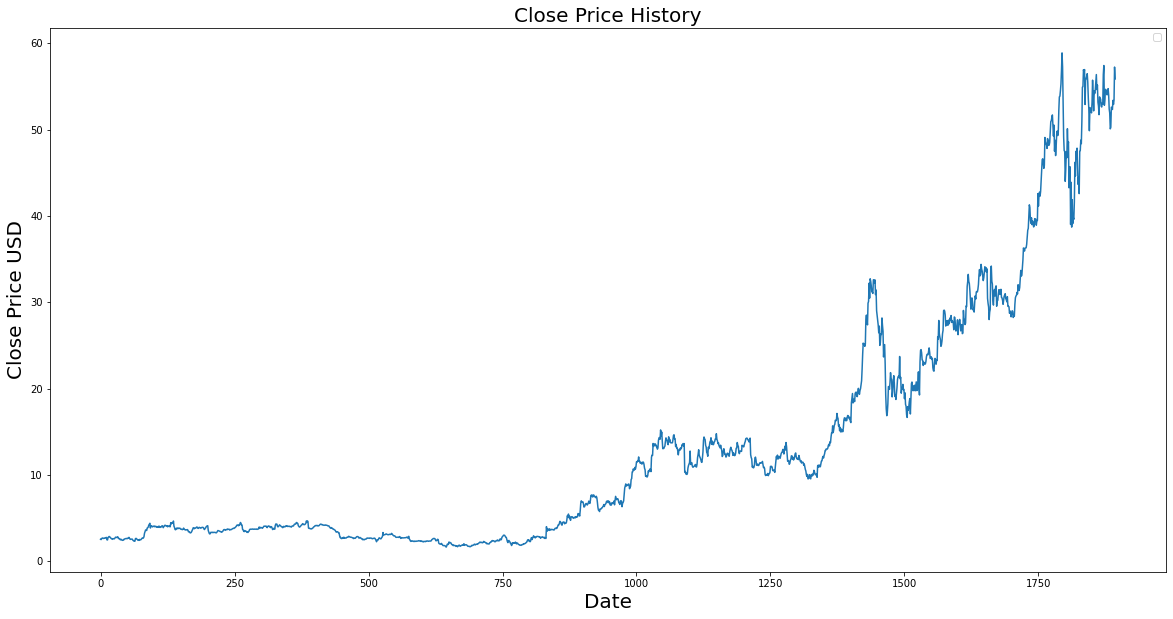

In [7]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("Close Price History", fontsize = 20)
plt.plot(amd['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize = 20)
plt.legend()
plt.show()

In [7]:
amd_month 

,Date,High,Low,Open,Close,Volume,Adj Close
0,2013-01-31,2.726667,2.592857,2.675714,2.654286,2.756779e+07,2.654286
1,2013-02-28,2.683158,2.582105,2.650000,2.624737,1.518843e+07,2.624737
2,2013-03-31,2.604500,2.518500,2.566500,2.561000,1.283063e+07,2.561000
3,2013-04-30,2.550909,2.442273,2.495000,2.510909,1.842465e+07,2.510909
4,2013-05-31,3.989545,3.775000,3.858636,3.906364,4.346387e+07,3.906364
...,...,...,...,...,...,...,...
86,2020-03-31,46.059091,42.778182,44.465909,44.424091,9.526760e+07,44.424091
87,2020-04-30,53.435714,50.806667,52.033809,52.063810,8.164641e+07,52.063810
88,2020-05-31,54.602000,52.276000,53.568000,53.503000,5.965888e+07,53.503000
89,2020-06-30,54.541363,52.498182,53.720000,53.490000,5.338069e+07,53.490000


No handles with labels found to put in legend.


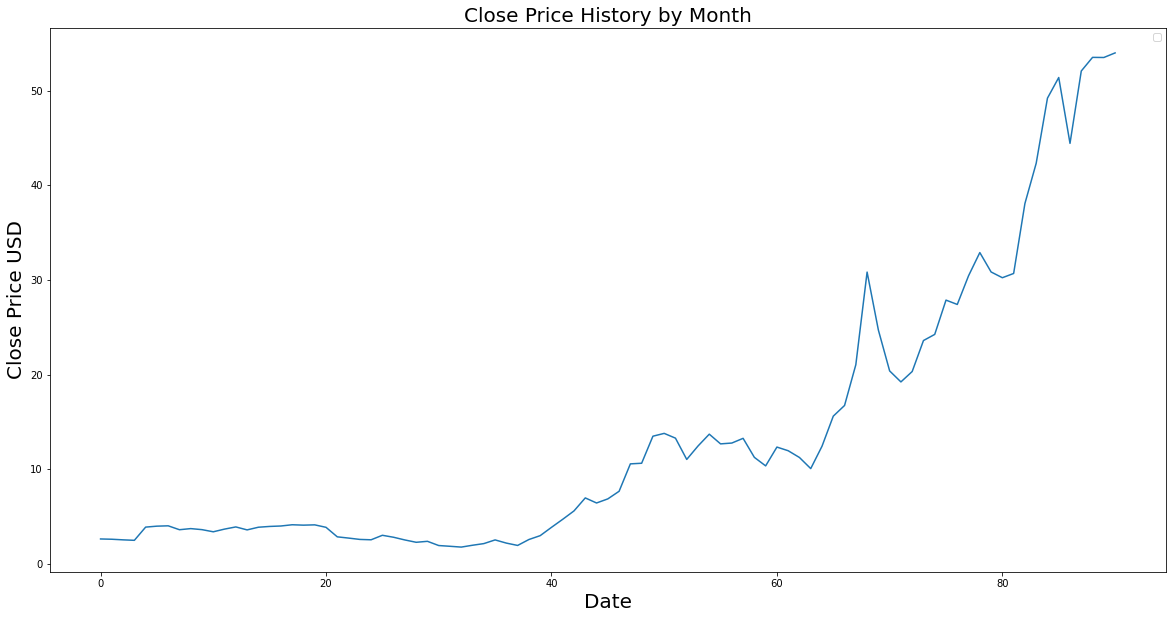

In [8]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("Close Price History by Month", fontsize = 20)
plt.plot(amd_month['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize = 20)
plt.legend()
plt.show()

In [9]:
amd_quarter

,Date,High,Low,Open,Close,Volume,Adj Close
0,2013-01-31,2.726667,2.592857,2.675714,2.654286,2.756779e+07,2.654286
1,2013-04-30,2.609672,2.510820,2.566721,2.562787,1.558254e+07,2.562787
2,2013-07-31,4.059375,3.893594,3.979531,3.984219,3.557207e+07,3.984219
3,2013-10-31,3.734615,3.615692,3.679385,3.669231,2.916816e+07,3.669231
4,2014-01-31,3.735323,3.625161,3.682903,3.681774,2.251086e+07,3.681774
5,2014-04-30,3.899836,3.778197,3.840820,3.834262,2.231302e+07,3.834262
6,2014-07-31,4.159219,4.032969,4.091406,4.096875,2.843739e+07,4.096875
7,2014-10-31,3.682615,3.570154,3.628308,3.612000,2.320845e+07,3.612000
8,2015-01-31,2.688689,2.585082,2.639344,2.637377,1.562466e+07,2.637377
9,2015-04-30,2.855161,2.750645,2.801290,2.800806,1.523658e+07,2.800806


No handles with labels found to put in legend.


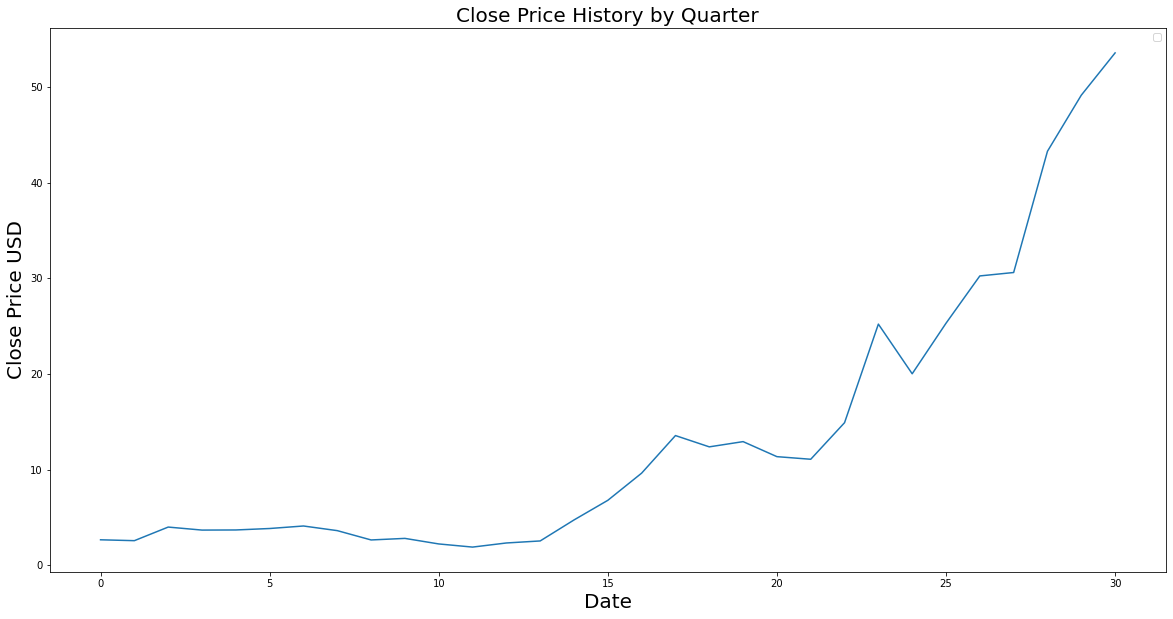

In [9]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("Close Price History by Quarter", fontsize = 20)
plt.plot(amd_quarter['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize = 20)
plt.legend()
plt.show()

In [11]:
amd_year

,Date,High,Low,Open,Close,Volume,Adj Close
0,2013-12-31,3.438373,3.316111,3.382222,3.378571,2.510814e+07,3.378571
1,2014-12-31,3.726389,3.608532,3.668175,3.662064,2.372125e+07,3.662064
2,2015-12-31,2.380873,2.280992,2.327579,2.331746,1.363467e+07,2.331746
3,2016-12-31,5.383849,5.114524,5.241508,5.254921,3.070861e+07,5.254921
4,2017-12-31,12.669283,12.164263,12.436614,12.411673,6.516145e+07,12.411673
5,2018-12-31,17.667610,16.729880,17.209681,17.214502,8.461100e+07,17.214502
6,2019-12-31,30.468690,29.384960,29.914921,29.941071,6.630142e+07,29.941071
7,2020-12-31,51.878931,49.530229,50.720992,50.753779,6.825434e+07,50.753779


No handles with labels found to put in legend.


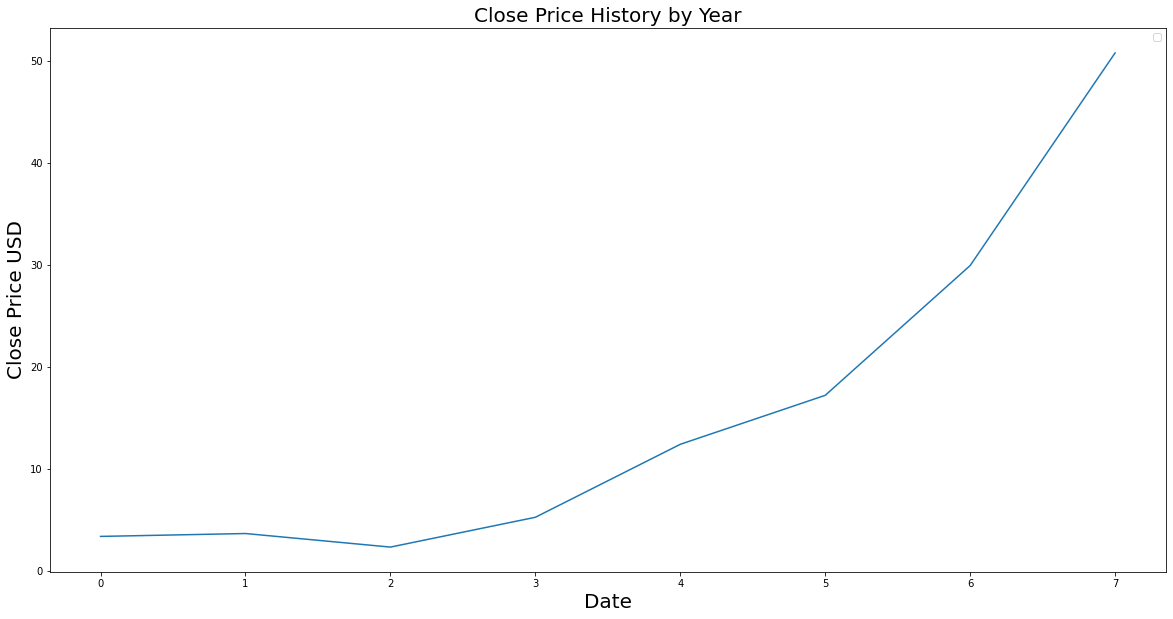

In [10]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("Close Price History by Year", fontsize = 20)
plt.plot(amd_year['Close'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Close Price USD', fontsize = 20)
plt.legend()
plt.show()

Export the data out to excel if desired

In [ ]:
# library needed for google importing or exporting
# from google.colab import files

# name your csv
# amd.to_csv('amd.csv') 

# download said csv
# files.download('amd.csv') 

In [11]:
# Check to see what kind of data type the data column in
amd.Date.dtype

dtype('<M8[ns]')

No handles with labels found to put in legend.


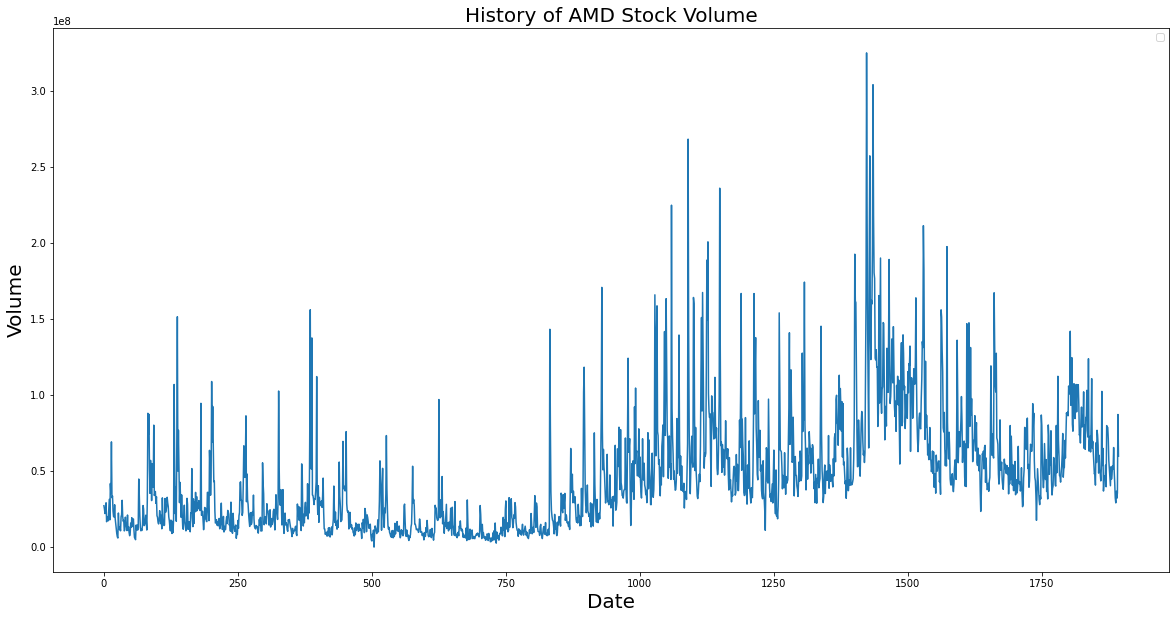

In [12]:
# Viaulize the price history of AMD stock
plt.figure(figsize=(20,10))
plt.title("History of AMD Stock Volume", fontsize = 20)
plt.plot(amd['Volume'])
plt.xlabel('Date', fontsize=20)
plt.ylabel('Volume', fontsize = 20)
plt.legend()
plt.show()

# Data Prepearation

Daily Data -

In [13]:
# The closing price will be what we forecast
amd_close = amd.drop(['High','Low','Open','Volume','Adj Close'], axis = 1)

# If the data is not in the appropriate format this code will change the date
# column to date time and the second line will convert Y or the price to a number
# In this case nothing is needed to be done
# amd_close['ds'] = pd.to_datetime(amd_close['Date'])
# amd_close['y'] = amd_close['Close'].astype(float)

# Rename the columns
amd_close = amd_close.rename(columns={'Date': 'ds', 'Close': 'y'})
amd_close

,ds,y
0,2013-01-02,2.530000
1,2013-01-03,2.490000
2,2013-01-04,2.590000
3,2013-01-07,2.670000
4,2013-01-08,2.670000
...,...,...
1889,2020-07-06,53.400002
1890,2020-07-07,52.930000
1891,2020-07-08,53.430000
1892,2020-07-09,57.259998


Monthly Data - 

In [14]:
# The closing price will be what we forecast
amd_month_close = amd_month.drop(['High','Low','Open','Volume','Adj Close'], axis = 1)

# If the data is not in the appropriate format this code will change the date
# column to date time and the second line will convert Y or the price to a number
# In this case nothing is needed to be done
# amd_month_close['ds'] = pd.to_datetime(amd_month_close['Date'])
# amd_month_close['y'] = amd_month_close['Close'].astype(float)

# Rename the columns
amd_month_close = amd_month_close.rename(columns={'Date': 'ds', 'Close': 'y'})
amd_month_close

,ds,y
0,2013-01-31,2.654286
1,2013-02-28,2.624737
2,2013-03-31,2.561000
3,2013-04-30,2.510909
4,2013-05-31,3.906364
...,...,...
86,2020-03-31,44.424091
87,2020-04-30,52.063810
88,2020-05-31,53.503000
89,2020-06-30,53.490000


Quarterly Data - 

In [15]:
# The closing price will be what we forecast
amd_quarter_close = amd_quarter.drop(['High','Low','Open','Volume','Adj Close'], axis = 1)

# If the data is not in the appropriate format this code will change the date
# column to date time and the second line will convert Y or the price to a number
# In this case nothing is needed to be done
# amd_quarter_close['ds'] = pd.to_datetime(amd_quarter_close['Date'])
# amd_quarter_close['y'] = amd_quarter_close['Close'].astype(float)

# Rename the columns
amd_quarter_close = amd_quarter_close.rename(columns={'Date': 'ds', 'Close': 'y'})
amd_quarter_close

,ds,y
0,2013-01-31,2.654286
1,2013-04-30,2.562787
2,2013-07-31,3.984219
3,2013-10-31,3.669231
4,2014-01-31,3.681774
5,2014-04-30,3.834262
6,2014-07-31,4.096875
7,2014-10-31,3.612000
8,2015-01-31,2.637377
9,2015-04-30,2.800806


Yearly Data - 

In [16]:
# The closing price will be what we forecast
amd_year_close = amd_year.drop(['High','Low','Open','Volume','Adj Close'], axis = 1)

# If the data is not in the appropriate format this code will change the date
# column to date time and the second line will convert Y or the price to a number
# In this case nothing is needed to be done
# amd_year_close['ds'] = pd.to_datetime(amd_year_close['Date'])
# amd_year_close['y'] = amd_year_close['Close'].astype(float)

# Rename the columns
amd_year_close = amd_year_close.rename(columns={'Date': 'ds', 'Close': 'y'})
amd_year_close

,ds,y
0,2013-12-31,3.378571
1,2014-12-31,3.662064
2,2015-12-31,2.331746
3,2016-12-31,5.254921
4,2017-12-31,12.411673
5,2018-12-31,17.214502
6,2019-12-31,29.941071
7,2020-12-31,50.792651


# Modeling

1st Model - Daily Volume Predicting for the next 2 months (60 days)

In [21]:
# Change the standard 80% to 95%
model = Prophet(interval_width=0.95)
# Fit the model
model.fit(amd_close)
# Forecast the future dates based on the data
future_dates = model.make_future_dataframe(periods=60)
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
1949,2020-09-04,59.097369,55.033902,63.085405
1950,2020-09-05,59.473660,55.387174,63.286490
1951,2020-09-06,59.562372,55.384218,63.626532
1952,2020-09-07,59.389601,55.335271,63.131058
1953,2020-09-08,59.512263,55.220648,63.479886


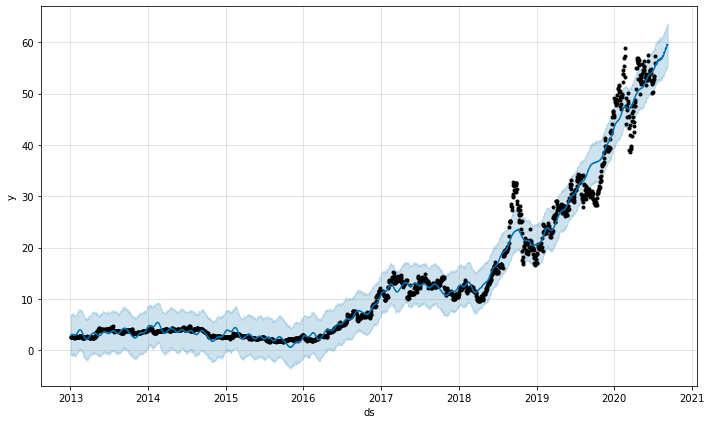

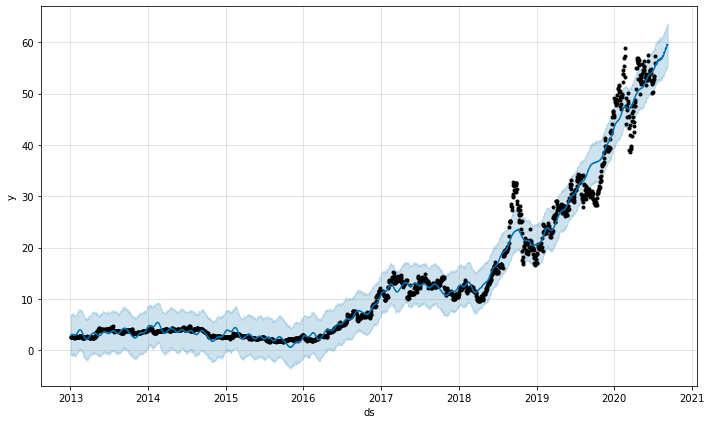

In [22]:
# Prophet plots the observed values of our time series (the black dots), 
# the forecasted values (blue line) and the uncertainty intervals of our 
# forecasts (the blue shaded regions).
model.plot(forecast, uncertainty = True, xlabel = 'ds', ylabel = 'y')

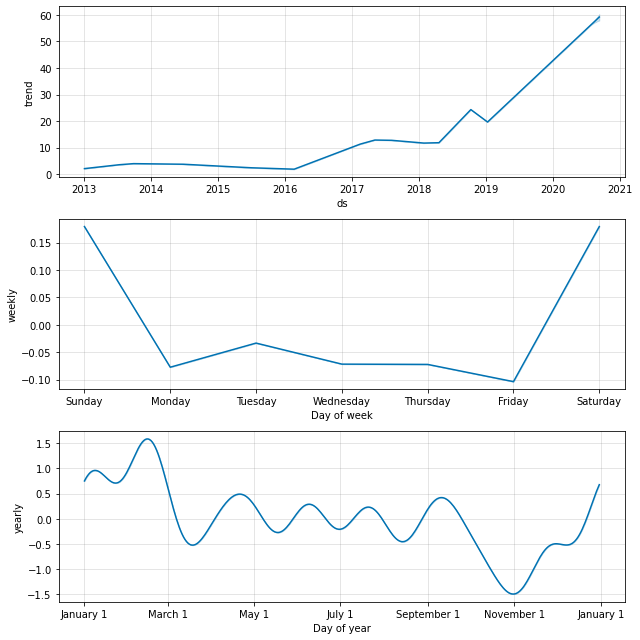

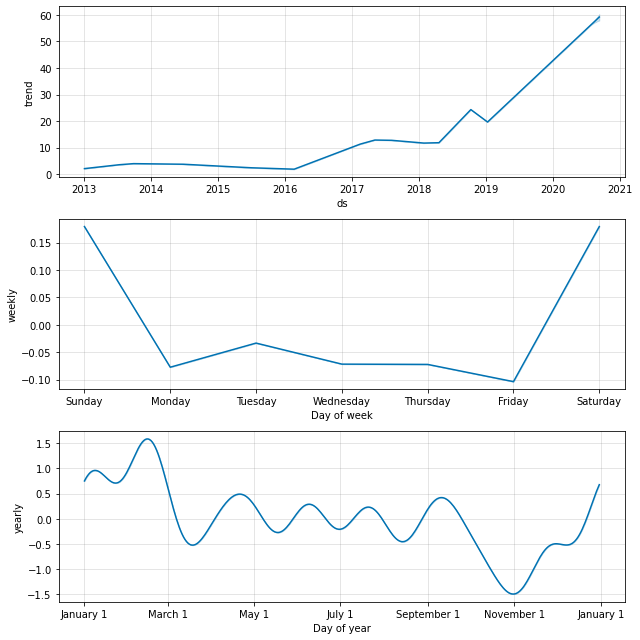

In [23]:
# Daily, weekly and yearly patterns
model.plot_components(forecast)